In [22]:
import time

import gym
import numpy as np
import torch
from torch.optim import Adam

import lyapunovrl.algos.pytorch.ppo.core as core
from lyapunovrl.utils.logx import EpochLogger
from lyapunovrl.utils.mpi_pytorch import (
    mpi_avg_grads,
    setup_pytorch_for_mpi,
    sync_params,
)
from lyapunovrl.utils.mpi_tools import (
    mpi_avg,
    mpi_fork,
    mpi_statistics_scalar,
    num_procs,
    proc_id,
)

import os
import safety_gym
from copy import deepcopy
from lyapunovrl.utils.run_utils import setup_logger_kwargs
from lyapunovrl.utils.mpi_tools import mpi_fork
from lyapunovrl.utils.gridnavigation import GridNavigationEnv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
# make the environment
# GridNav-v1 has gridsize 60
env = gym.make("GridNav-v1")

/opt/homebrew/Caskroom/miniforge/base/envs/openai_safety_gym_env/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


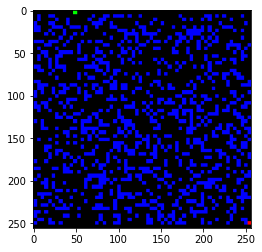

In [3]:
# get the action space
action_space = env.action_space
# get the observation space
observation_space = env.observation_space

# sample an action
action = action_space.sample()
# reset the environment
env.reset()
observation, reward, done, info = env.step(action)
env.render()
c_cost = info["constraint_costs"]

In [13]:
# initialize the importance weights w_0, w_d_0, w_t_0 as 1
w_0 = 1
w_d_0 = 1
w_t_0 = 1
# initialize mini-batch size
batch_size = 128
# initialize the discount factor
gamma = 0.99

In [17]:
# number of policy updates per epoch
num_policy_updates = 10
# time-out for the environment
time_out = 100